<a href="https://colab.research.google.com/github/eklavya172004/Informational-Retrieval--project-/blob/main/SUBMITTED_IR_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
# --------------------------------
# 1. Mount Google Drive
# --------------------------------
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
import os
import re
import zipfile
import numpy as np
import pandas as pd
from collections import defaultdict

In [136]:
ZIP_PATH = "/content/drive/MyDrive/wikipedia_corpus_clean.zip"

In [85]:
import os

CORPUS_DIR = "/content/clean_corpus"

print("=== List of All Documents in Corpus ===\n")
docs = sorted(os.listdir(CORPUS_DIR))

for i, fname in enumerate(docs):
    print(f"{i}. {fname}")


=== List of All Documents in Corpus ===

0. Acne vulgaris.txt
1. Addison's disease.txt
2. Allergic rhinitis.txt
3. Allergies.txt
4. Alopecia areata.txt
5. Alzheimer's disease.txt
6. Amyotrophic lateral sclerosis (ALS).txt
7. Anemia.txt
8. Anxiety disorder.txt
9. Aortic stenosis.txt
10. Aphasia.txt
11. Appendicitis.txt
12. Asthma.txt
13. Atherosclerosis.txt
14. Attention-Deficit Hyperactivity Disorder.txt
15. Autism spectrum disorder.txt
16. Bells palsy.txt
17. Bipolar disorder.txt
18. Bladder cancer.txt
19. Botulism.txt
20. Breast cancer.txt
21. Bursitis.txt
22. COVID-19.txt
23. Candidiasis.txt
24. Carpal tunnel syndrome.txt
25. Cataract.txt
26. Cataracts.txt
27. Celiac disease.txt
28. Cellulitis.txt
29. Cerebral palsy.txt
30. Chlamydia.txt
31. Cholera.txt
32. Chronic kidney disease.txt
33. Cirrhosis.txt
34. Colorectal cancer.txt
35. Common cold.txt
36. Concussion.txt
37. Congestive heart failure.txt
38. Conjunctivitis.txt
39. Coronary heart disease.txt
40. Crohn's disease.txt
41. Cush

In [86]:
# ---------------------------
# 3. NLTK + CLASSIC CLEANING
# ---------------------------
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def classic_clean(text):
    text = (text or "").lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [87]:
# ----------------------
# 4. LOAD ZIP
# ----------------------
def load_zip(zip_path):
    docs = []
    with zipfile.ZipFile(zip_path, "r") as z:
        for name in z.namelist():
            if name.lower().endswith(".txt"):
                raw = z.read(name).decode("utf-8", errors="ignore")
                docs.append((os.path.splitext(os.path.basename(name))[0], raw))
    df = pd.DataFrame(docs, columns=["title", "text"])
    return df

df = load_zip(ZIP_PATH)
print(f"\n=== Loaded {len(df)} documents ===\n")


=== Loaded 177 documents ===



In [88]:
# ---------------------------
# 5. CLEAN CORPUS
# ---------------------------
df["clean"] = df["text"].apply(classic_clean)

In [89]:
# --------------------------------
# 6. Save Cleaned Corpus
# --------------------------------
SAVE_DIR = "/content/clean_corpus"
os.makedirs(SAVE_DIR, exist_ok=True)

for i, row in df.iterrows():
    with open(f"{SAVE_DIR}/{row['title']}.txt", "w", encoding="utf-8") as f:
        f.write(row["clean"])

print("Saved cleaned corpus to:", SAVE_DIR)


Saved cleaned corpus to: /content/clean_corpus


In [90]:
# ----------------------
# 6. TF-IDF VECTOR SPACE MODEL
# ----------------------
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_mat = tfidf.fit_transform(df["clean"])

print("TF-IDF vocabulary size:", len(tfidf.vocabulary_))
print("TF-IDF matrix shape:", tfidf_mat.shape, "\n")


TF-IDF vocabulary size: 27841
TF-IDF matrix shape: (177, 27841) 



In [91]:
# ----------------------
# 7. BM25
# ----------------------
!pip install rank_bm25 > /dev/null
from rank_bm25 import BM25Okapi

bm25 = BM25Okapi([d.split() for d in df["clean"]])
print("BM25 corpus loaded with", len(df), "documents\n")

BM25 corpus loaded with 177 documents



In [92]:
# ----------------------
# 8. VSM (Count Vectorizer)
# ----------------------
from sklearn.feature_extraction.text import CountVectorizer
vsm_vect = CountVectorizer()
vsm_mat = vsm_vect.fit_transform(df["clean"])

print("VSM vocabulary size:", len(vsm_vect.vocabulary_))
print("VSM matrix shape:", vsm_mat.shape, "\n")

VSM vocabulary size: 27841
VSM matrix shape: (177, 27841) 



In [93]:
# ----------------------
# 9. INVERTED INDEX
# ----------------------
inverted = defaultdict(set)
for doc_id, text in enumerate(df["clean"]):
    for term in text.split():
        inverted[term].add(doc_id)

print("Inverted index unique terms:", len(inverted))
print("\nSample postings:")
sample_terms = list(inverted.keys())[:10]
for t in sample_terms:
    print(f"{t} -> {sorted(list(inverted[t]))}")
print("\n")


Inverted index unique terms: 27856

Sample postings:
concussion -> [0, 173]
also -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176]
known -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 

In [94]:
# ----------------------
# 10. Similarity Matrix for PageRank / HITS
# ----------------------
sim = (tfidf_mat @ tfidf_mat.T).toarray()
np.fill_diagonal(sim, 0)
row_sum = sim.sum(axis=1, keepdims=True)
P = sim / (row_sum + 1e-12)

In [95]:
# ----------------------
# 11. PAGE RANK
# ----------------------
def pagerank(P, d=0.85, max_iter=100):
    n = len(P)
    r = np.ones(n)/n
    for _ in range(max_iter):
        r_new = d*(P.T@r) + (1-d)/n
        if np.linalg.norm(r_new-r,1) < 1e-6:
            break
        r = r_new
    return r

df["pagerank"] = pagerank(P)

print("=== TOP 10 PAGERANK DOCUMENTS ===")
print(df.sort_values("pagerank", ascending=False)[["title","pagerank"]].head(10), "\n")


=== TOP 10 PAGERANK DOCUMENTS ===
                         title  pagerank
160              Down syndrome  0.009778
175     Ischemic heart disease  0.009177
67      Coronary heart disease  0.009142
129  Major Depressive Disorder  0.008761
14   Major depressive disorder  0.008754
163                  Pneumonia  0.008644
61       Myocardial infarction  0.008642
25    Diabetes mellitus type 2  0.008607
161                Common cold  0.008353
153            Gastroenteritis  0.008253 



In [96]:
# ----------------------
# 12. HITS (Hub / Authority)
# ----------------------
def hits(P, max_iter=100):
    n = len(P)
    h = np.ones(n)
    a = np.ones(n)
    for _ in range(max_iter):
        a_new = P.T @ h
        h_new = P @ a_new
        a_new /= np.linalg.norm(a_new)
        h_new /= np.linalg.norm(h_new)
        a, h = a_new, h_new
    return h, a

hub, auth = hits(P)
df["hub"] = hub
df["authority"] = auth

print("=== TOP 10 AUTHORITY SCORES ===")
print(df.sort_values("authority", ascending=False)[["title","authority"]].head(10), "\n")

print("=== TOP 10 HUB SCORES ===")
print(df.sort_values("hub", ascending=False)[["title","hub"]].head(10), "\n")



=== TOP 10 AUTHORITY SCORES ===
                         title  authority
160              Down syndrome   0.135993
175     Ischemic heart disease   0.119719
67      Coronary heart disease   0.119176
129  Major Depressive Disorder   0.118618
14   Major depressive disorder   0.118508
163                  Pneumonia   0.116342
25    Diabetes mellitus type 2   0.113882
61       Myocardial infarction   0.113614
161                Common cold   0.112442
153            Gastroenteritis   0.112329 

=== TOP 10 HUB SCORES ===
                          title       hub
17   Hypertensive heart disease  0.081446
67       Coronary heart disease  0.079600
175      Ischemic heart disease  0.079549
84                Heart failure  0.078859
116    Congestive heart failure  0.078852
61        Myocardial infarction  0.078318
145             Atherosclerosis  0.078146
43               Hyperlipidemia  0.077726
37           Metabolic syndrome  0.077675
77                 Pericarditis  0.077553 



In [97]:
# ----------------------
# 13. KMEANS CLUSTERING
# ----------------------
from sklearn.cluster import KMeans

k = min(8, max(2, len(df)//40))
kmeans = KMeans(n_clusters=k, n_init=10)
df["cluster"] = kmeans.fit_predict(tfidf_mat)

print(f"=== CLUSTER DISTRIBUTION (k={k}) ===")
print(df["cluster"].value_counts(), "\n")

print("=== SAMPLE DOCS FROM EACH CLUSTER ===")
for cl in range(k):
    sample = df[df["cluster"] == cl].head(3)["title"].tolist()
    print(f"Cluster {cl}:", sample)
print("\n")

=== CLUSTER DISTRIBUTION (k=4) ===
cluster
2    115
3     34
1     15
0     13
Name: count, dtype: int64 

=== SAMPLE DOCS FROM EACH CLUSTER ===
Cluster 0: ['Lung cancer', 'Human papillomavirus', 'Ovarian cancer']
Cluster 1: ['Pneumoconiosis', 'Hemochromatosis', 'Cystic fibrosis']
Cluster 2: ['Concussion', 'Celiac disease', "Huntington's disease"]
Cluster 3: ['Syphilis', 'Herpes simplex', 'Toxoplasmosis']




In [98]:
# ----------------------
# 14. NAIVE BAYES CLASSIFICATION (toy labels)
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X = vsm_mat
y = df.index % 2  # dummy labels

X_train, X_test, y_train, y_test = train_test_split(X, y)
nb = MultinomialNB().fit(X_train, y_train)
acc = nb.score(X_test, y_test)

print("=== NAIVE BAYES ACCURACY ===")
print("Accuracy:", acc, "\n")

preds = nb.predict(X_test[:10])
print("=== SAMPLE NB PREDICTIONS ===")
print("Pred:", preds)
print("True:", y_test[:10].tolist(), "\n")


=== NAIVE BAYES ACCURACY ===
Accuracy: 0.4444444444444444 

=== SAMPLE NB PREDICTIONS ===
Pred: [0 0 0 1 1 1 0 0 0 0]
True: [1, 0, 1, 1, 1, 0, 0, 1, 1, 1] 



In [99]:
# If clean() isn’t defined because you ran cells out of order, redefine it here:
def clean(text):
    text = (text or "").lower()
    import re
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    tokens = [t for t in text.split() if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)


In [100]:
# ----------------------
# 15. SEARCH DEMOS (TF-IDF, BM25, VSM)
# ----------------------
query = "computer science"
q_clean = clean(query)

print("\n========================================")
print("         SEARCH RESULTS")
print("========================================")

# TF-IDF
from sklearn.metrics.pairwise import cosine_similarity
q_vec = tfidf.transform([q_clean])
tfidf_scores = cosine_similarity(q_vec, tfidf_mat).flatten()

top = tfidf_scores.argsort()[::-1][:10]
print("\nTF-IDF top 10")
for i in top:
    print(f"{df.loc[i,'title']}  -> {tfidf_scores[i]:.4f}")

# BM25
bm25_scores = bm25.get_scores(q_clean.split())
top = np.argsort(bm25_scores)[::-1][:10]
print("\nBM25 top 10")
for i in top:
    print(f"{df.loc[i,'title']}  -> {bm25_scores[i]:.4f}")

# VSM
q_vec_vsm = vsm_vect.transform([q_clean])
vsm_scores = cosine_similarity(q_vec_vsm, vsm_mat).flatten()
top = vsm_scores.argsort()[::-1][:10]
print("\nVSM top 10")
for i in top:
    print(f"{df.loc[i,'title']}  -> {vsm_scores[i]:.4f}")

print("\n=== ALL RESULTS DISPLAYED ===\n")


         SEARCH RESULTS

TF-IDF top 10
Endocarditis  -> 0.0396
E. coli infection  -> 0.0196
Carpal tunnel syndrome  -> 0.0144
Tonsillitis  -> 0.0141
Pleurisy  -> 0.0104
Conjunctivitis  -> 0.0086
Common cold  -> 0.0084
Diabetes mellitus type 2  -> 0.0081
Insomnia  -> 0.0077
Hepatitis C  -> 0.0067

BM25 top 10
E. coli infection  -> 6.9966
Endocarditis  -> 5.2360
Carpal tunnel syndrome  -> 4.6218
Pleurisy  -> 3.5962
Conjunctivitis  -> 3.5173
Insomnia  -> 3.4887
Tonsillitis  -> 3.3285
Dyslexia  -> 3.0826
Diabetes mellitus type 2  -> 2.9140
Cholera  -> 2.7587

VSM top 10
Endocarditis  -> 0.0312
E. coli infection  -> 0.0175
Tonsillitis  -> 0.0165
Carpal tunnel syndrome  -> 0.0108
Cholera  -> 0.0074
Hepatitis C  -> 0.0064
Pleurisy  -> 0.0063
Common cold  -> 0.0061
Conjunctivitis  -> 0.0059
Dyslexia  -> 0.0047

=== ALL RESULTS DISPLAYED ===



In [101]:
# --------------------------------
# QUERY EXPANSION (WORDNET)
# --------------------------------
from nltk.corpus import wordnet as wn

def expand_query_wordnet(query):
    q_clean = clean(query)
    tokens = q_clean.split()

    expanded = set(tokens)

    for word in tokens:
        for syn in wn.synsets(word):
            for lemma in syn.lemmas():
                name = lemma.name().replace("_", " ")
                if name.isalpha() and len(name) > 2:
                    expanded.add(name.lower())

    return " ".join(list(expanded))


In [102]:
# ---------------------------------------------------------
# SUPER-CLEAN CORPUS QUERY EXPANSION (NO DRUG NAMES, NO CODES)
# ---------------------------------------------------------
from collections import Counter

def is_valid_general_word(w):
    # Reject numbers or mixed tokens
    if not w.isalpha():
        return False

    # Reject very short/long tokens
    if len(w) < 3 or len(w) > 10:
        return False

    # Reject biomedical junk patterns
    bad_suffixes = [
        "ib", "inib", "tinib", "fenib",
        "umab", "vir", "viro", "ase",
        "cept", "platin", "nib"
    ]
    for suf in bad_suffixes:
        if w.endswith(suf):
            return False

    # Reject all-caps weird tokens
    if w.isupper():
        return False

    return True


def expand_query_corpus(query, top_docs=5, top_terms=5):
    q_clean = clean(query)
    q_vec = tfidf.transform([q_clean])

    # similarity scores
    scores = cosine_similarity(q_vec, tfidf_mat).flatten()
    top_idx = scores.argsort()[::-1][:top_docs]

    # collect tokens from top docs
    doc_text = " ".join(df.loc[i, "clean"] for i in top_idx)
    tokens = doc_text.split()

    # Count term frequency across top docs
    freq = Counter(tokens)

    # Keep only general English-like words
    filtered = [w for w in tokens if is_valid_general_word(w)]

    # Keep only words that appear at least twice (removes rare drugs)
    filtered = [w for w in filtered if freq[w] >= 2]

    # Remove query words themselves
    filtered = [w for w in filtered if w not in q_clean.split()]

    # Unique terms
    uniq = list(set(filtered))

    if not uniq:
        return q_clean   # fallback: no expansion

    # Select top-N most common general words
    common_terms = Counter(filtered).most_common(top_terms)
    expansion_terms = [term for term, _ in common_terms]

    final_query = q_clean + " " + " ".join(expansion_terms)
    return final_query


In [103]:
# ============================================================
#               ROCCHIO RELEVANCE FEEDBACK (FIXED)
# ============================================================

def rocchio_feedback(query_vec, relevant_docs, non_relevant_docs,
                     alpha=1.0, beta=0.75, gamma=0.15):

    new_q = alpha * query_vec  # preserve original query

    # Add relevant documents
    if len(relevant_docs) > 0:
        rel_vecs = tfidf_mat[relevant_docs].mean(axis=0)
        new_q = new_q + beta * rel_vecs

    # Subtract non-relevant documents
    if len(non_relevant_docs) > 0:
        nonrel_vecs = tfidf_mat[non_relevant_docs].mean(axis=0)
        new_q = new_q - gamma * nonrel_vecs

    # ⭐ Convert to proper numpy array (avoids np.matrix errors)
    return np.asarray(new_q)


# ============================================================
#          INTERACTIVE IR SEARCH WITH QUERY EXPANSION
# ============================================================

def interactive_search(query, top_k=10):

    # Apply both expansions
    expanded = expand_query_wordnet(query)
    expanded = expand_query_corpus(expanded)

    print("\n===============================")
    print("       ORIGINAL QUERY:", query)
    print("       EXPANDED QUERY:", expanded)
    print("===============================\n")

    q_clean = expanded

    # -----------------------------------------------------------
    # TF-IDF
    # -----------------------------------------------------------
    q_vec = tfidf.transform([q_clean])
    tfidf_scores = cosine_similarity(q_vec, tfidf_mat).flatten()
    top_tfidf = tfidf_scores.argsort()[::-1][:top_k]

    print("🔵 TF-IDF Results:")
    for i in top_tfidf:
        print(f"{i}. {df.loc[i,'title']} (score={tfidf_scores[i]:.4f})")
    print("\n")

    # -----------------------------------------------------------
    # BM25
    # -----------------------------------------------------------
    bm25_scores = bm25.get_scores(q_clean.split())
    top_bm25 = np.argsort(bm25_scores)[::-1][:top_k]

    print("🟢 BM25 Results:")
    for i in top_bm25:
        print(f"{i}. {df.loc[i,'title']} (score={bm25_scores[i]:.4f})")
    print("\n")

    # -----------------------------------------------------------
    # VSM
    # -----------------------------------------------------------
    q_vec_vsm = vsm_vect.transform([q_clean])
    vsm_scores = cosine_similarity(q_vec_vsm, vsm_mat).flatten()
    top_vsm = vsm_scores.argsort()[::-1][:top_k]

    print("🟣 VSM Results:")
    for i in top_vsm:
        print(f"{i}. {df.loc[i,'title']} (score={vsm_scores[i]:.4f})")
    print("\n")

    # -----------------------------------------------------------
    # PAGE RANK
    # -----------------------------------------------------------
    top_pr = df.sort_values("pagerank", ascending=False).head(top_k)

    print("🟡 Top PageRank Documents:")
    for idx, row in top_pr.iterrows():
        print(f"• {row['title']} (pagerank={row['pagerank']:.6f})")
    print("\n")

    # -----------------------------------------------------------
    # HITS
    # -----------------------------------------------------------
    print("🔴 Top Authorities:")
    top_auth = df.sort_values("authority", ascending=False).head(top_k)
    for idx, row in top_auth.iterrows():
        print(f"• {row['title']} (authority={row['authority']:.6f})")

    print("\n🟠 Top Hubs:")
    top_hub = df.sort_values("hub", ascending=False).head(top_k)
    for idx, row in top_hub.iterrows():
        print(f"• {row['title']} (hub={row['hub']:.6f})")
    print("\n")

    # -----------------------------------------------------------
    # CLUSTER MEMBERSHIP
    # -----------------------------------------------------------
    tfidf_query_vec = tfidf.transform([q_clean])
    cluster = kmeans.predict(tfidf_query_vec)[0]

    print("🟤 Query belongs to Cluster:", cluster)
    print("Sample docs from this cluster:")
    print(df[df["cluster"] == cluster].head(5)["title"].tolist())
    print("\n")

    return q_vec   # needed for Rocchio


# ============================================================
#                   CLEAN SINGLE LOOP
# ============================================================

while True:

    query = input("\nEnter your search query (type 'quit' to exit): ").strip()
    if query.lower() in ["quit", "exit", "q"]:
        print("\nExiting IR system... Goodbye!")
        break

    # run normal search & get query vector
    q_vec = interactive_search(query)

    # Ask user if they want Rocchio feedback
    fb = input("Do you want to give relevance feedback? (y/n): ").strip().lower()

    if fb != "y":
        continue

    # let user enter doc IDs
    rel = input("Enter relevant doc IDs (comma-separated): ").strip()
    nonrel = input("Enter non-relevant doc IDs (comma-separated): ").strip()

    relevant_docs = list(map(int, rel.split(","))) if rel else []
    non_relevant_docs = list(map(int, nonrel.split(","))) if nonrel else []

    # compute improved query vector
    new_q_vec = rocchio_feedback(q_vec, relevant_docs, non_relevant_docs)

    # re-rank all documents
    new_scores = cosine_similarity(new_q_vec, tfidf_mat).flatten()
    new_top = new_scores.argsort()[::-1][:10]

    print("\n🔁 Improved Results After Rocchio Feedback:")
    for i in new_top:
        print(f"{i}. {df.loc[i,'title']} (new score={new_scores[i]:.4f})")



Enter your search query (type 'quit' to exit): quit

Exiting IR system... Goodbye!


In [104]:
# ============================================================
#              DISEASE GROUPS (MANUAL CLUSTERS)
# ============================================================

infectious = [
 "Syphilis", "Herpes simplex", "Toxoplasmosis",
 "Ebola virus disease", "Hepatitis C", "Rubella",
 "Warts", "Otitis media"
]

respiratory = [
 "Asthma", "Lung cancer", "Pneumoconiosis", "Vertigo"
]

metabolic = [
 "Metabolic syndrome", "Hyperlipidemia", "Hypertension",
 "Non-alcoholic fatty liver disease (NAFLD)", "Gout"
]

neurological = [
 "Concussion", "Huntington's disease", "Cerebral palsy", "Vertigo"
]

mental_health = [
 "Major depressive disorder", "Anxiety disorder",
 "Generalized Anxiety Disorder",
 "Attention-Deficit Hyperactivity Disorder"
]

genetic = [
 "Cystic fibrosis", "Ehlers-Danlos syndrome",
 "Hemochromatosis", "Celiac disease"
]

immune = [
 "Celiac disease", "Allergies", "Asthma"
]

gastro = [
 "Gastroesophageal Reflux Disease",
 "Non-alcoholic fatty liver disease (NAFLD)",
 "Celiac disease"
]

musculoskeletal = [
 "Gout", "Ehlers-Danlos syndrome"
]


In [105]:
import pandas as pd

def show_group(name, disease_list, color):
    df_group = pd.DataFrame({"Disease": disease_list})

    styler = df_group.style.set_caption(name).set_table_styles([
        {'selector': 'caption',
         'props': [('color', color),
                   ('font-size', '20px'),
                   ('font-weight', 'bold'),
                   ('text-align', 'left')]},
        {'selector': 'th.col_heading',
         'props': [('background-color', color),
                   ('color', 'white'),
                   ('font-size', '15px'),
                   ('text-align','left')]}
    ])

    # Remove index manually using CSS (works in ALL pandas versions)
    styler = styler.set_table_styles([
        {'selector': 'th.row_heading', 'props': [('display', 'none')]},
        {'selector': 'th.blank', 'props': [('display', 'none')]}
    ], overwrite=False)

    return styler



In [106]:
from IPython.display import display
display(show_group("🦠 Infectious Diseases", infectious, "#d9534f"))
display(show_group("🫁 Respiratory Diseases", respiratory, "#5bc0de"))
display(show_group("🍔 Metabolic Disorders", metabolic, "#f0ad4e"))
display(show_group("🧠 Neurological Disorders", neurological, "#428bca"))
display(show_group("😔 Mental Health Disorders", mental_health, "#6f42c1"))
display(show_group("🧬 Genetic Disorders", genetic, "#5cb85c"))
display(show_group("🧪 Immune Disorders", immune, "#0275d8"))
display(show_group("🩺 Gastrointestinal Disorders", gastro, "#d58512"))
display(show_group("🦴 Musculoskeletal Disorders", musculoskeletal, "#8a6d3b"))



,Disease
0,Syphilis
1,Herpes simplex
2,Toxoplasmosis
3,Ebola virus disease
4,Hepatitis C
5,Rubella
6,Warts
7,Otitis media


,Disease
0,Asthma
1,Lung cancer
2,Pneumoconiosis
3,Vertigo


,Disease
0,Metabolic syndrome
1,Hyperlipidemia
2,Hypertension
3,Non-alcoholic fatty liver disease (NAFLD)
4,Gout


,Disease
0,Concussion
1,Huntington's disease
2,Cerebral palsy
3,Vertigo


,Disease
0,Major depressive disorder
1,Anxiety disorder
2,Generalized Anxiety Disorder
3,Attention-Deficit Hyperactivity Disorder


,Disease
0,Cystic fibrosis
1,Ehlers-Danlos syndrome
2,Hemochromatosis
3,Celiac disease


,Disease
0,Celiac disease
1,Allergies
2,Asthma


,Disease
0,Gastroesophageal Reflux Disease
1,Non-alcoholic fatty liver disease (NAFLD)
2,Celiac disease


,Disease
0,Gout
1,Ehlers-Danlos syndrome



Graph created with 177 nodes and 134 edges.

=== TOP 15 DISEASES BY GRAPH-BASED PAGERANK ===
                         title  graph_pagerank
12                 Lung cancer        0.020729
175     Ischemic heart disease        0.018742
67      Coronary heart disease        0.018709
176                Hepatitis A        0.017433
160              Down syndrome        0.017311
150                Pharyngitis        0.015521
137             Thyroid cancer        0.015513
60              Bladder cancer        0.015414
54                      Anemia        0.015269
129  Major Depressive Disorder        0.014953
14   Major depressive disorder        0.014952
15                 Bells palsy        0.014887
47                   Allergies        0.014887
174               Yellow fever        0.014854
61       Myocardial infarction        0.014636


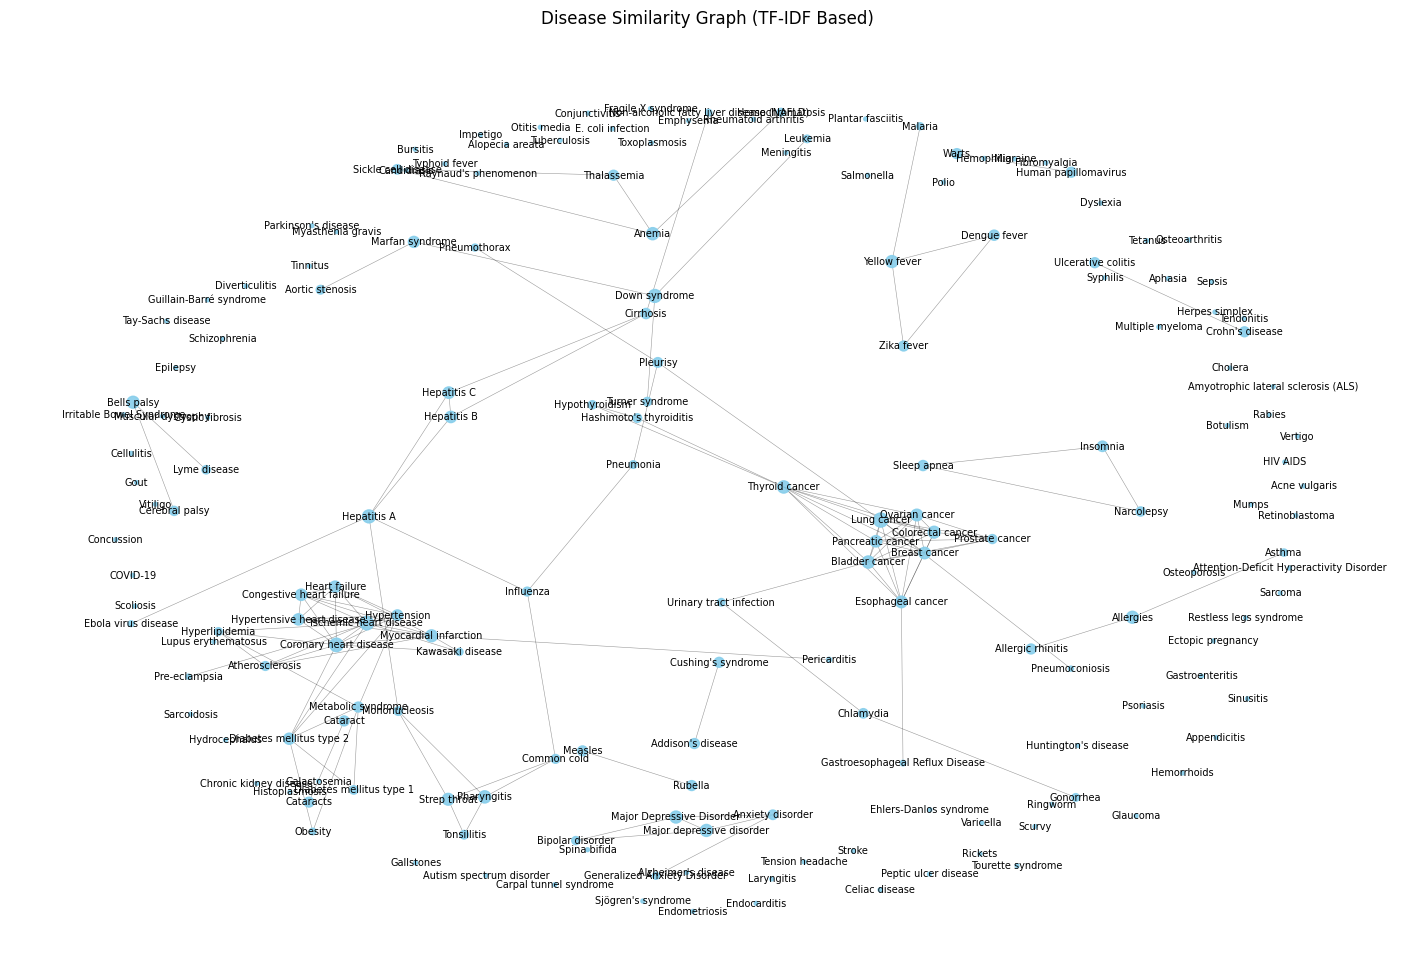

In [107]:
# =============================================================
#            DISEASE SIMILARITY GRAPH + PAGERANK
# =============================================================

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# -------------------------------
# 1. Build cosine similarity matrix
# -------------------------------
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tfidf_mat)

# -------------------------------
# 2. Build graph using threshold
# -------------------------------
THRESHOLD = 0.20   # you can adjust this

G = nx.Graph()

# Add all diseases as nodes
for i, row in df.iterrows():
    G.add_node(i, label=row["title"])

# Add edges for similarity above threshold
for i in range(len(df)):
    for j in range(i+1, len(df)):
        sim = similarity_matrix[i][j]
        if sim >= THRESHOLD:
            G.add_edge(i, j, weight=sim)

print(f"\nGraph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# -------------------------------
# 3. Run PageRank on the graph
# -------------------------------
pr_scores = nx.pagerank(G, weight='weight')
df["graph_pagerank"] = df.index.map(pr_scores)

print("\n=== TOP 15 DISEASES BY GRAPH-BASED PAGERANK ===")
print(df.sort_values("graph_pagerank", ascending=False)[["title", "graph_pagerank"]].head(15))

# -------------------------------
# 4. Visualize the graph
# -------------------------------
plt.figure(figsize=(18, 12))

pos = nx.spring_layout(G, k=0.25, iterations=50)

# Node sizes based on PageRank
sizes = [5000 * df.loc[n, "graph_pagerank"] for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='skyblue', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=0.4, alpha=0.4)
nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=7)

plt.title("Disease Similarity Graph (TF-IDF Based)")
plt.axis("off")
plt.show()


In [108]:
# Get 3 sample disease names from each cluster for labeling
cluster_labels = {}

for cl in sorted(df["cluster"].unique()):
    names = df[df["cluster"] == cl]["title"].head(3).tolist()
    cluster_labels[cl] = ", ".join(names)


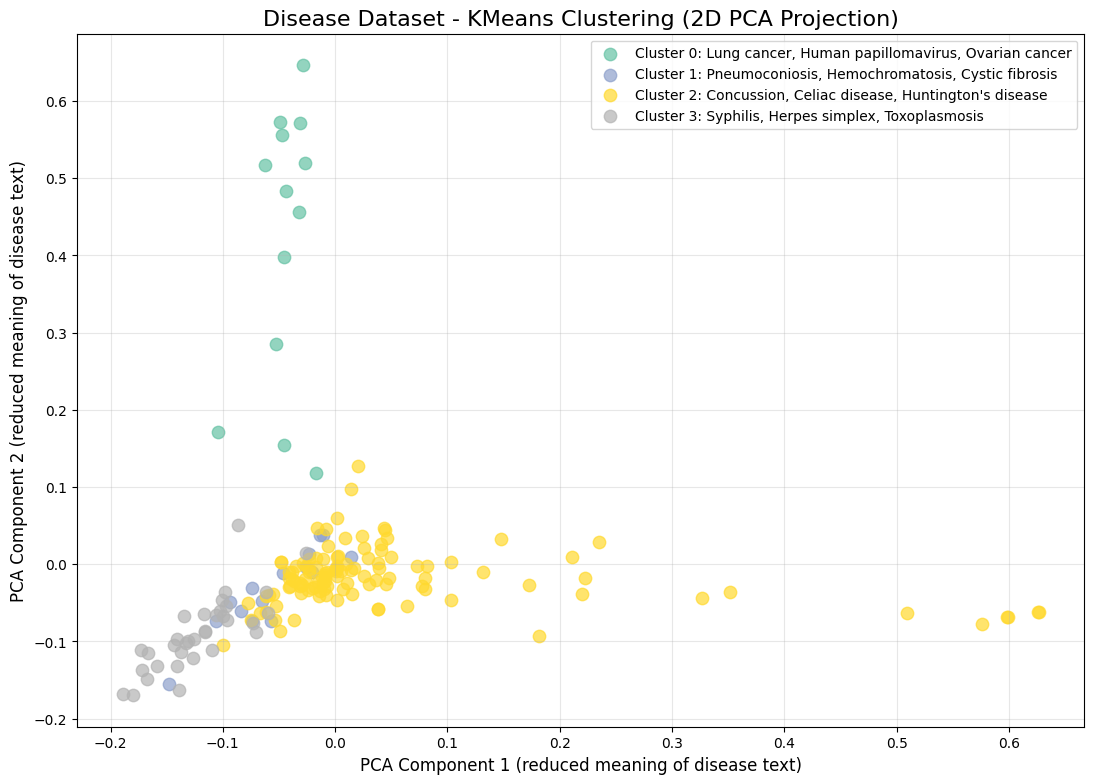

In [109]:
# ============================================================
#      BEGINNER-FRIENDLY KMEANS CLUSTERING VISUALIZATION
# ============================================================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce vectors to 2D for plotting
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_mat.toarray())

df["pca_x"] = reduced[:, 0]
df["pca_y"] = reduced[:, 1]

# Prepare colors
num_clusters = df["cluster"].nunique()
colors = plt.cm.Set2(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(13, 9))

for cl in sorted(df["cluster"].unique()):
    cluster_points = df[df["cluster"] == cl]

    plt.scatter(
        cluster_points["pca_x"],
        cluster_points["pca_y"],
        color=colors[cl],
        s=80,
        alpha=0.7,
        label=f"Cluster {cl}: {cluster_labels[cl]}"
    )

# Title + axes + explanation
plt.title("Disease Dataset - KMeans Clustering (2D PCA Projection)", fontsize=16)
plt.xlabel("PCA Component 1 (reduced meaning of disease text)", fontsize=12)
plt.ylabel("PCA Component 2 (reduced meaning of disease text)", fontsize=12)

plt.legend(loc="best", fontsize=10)
plt.grid(alpha=0.3)
plt.show()


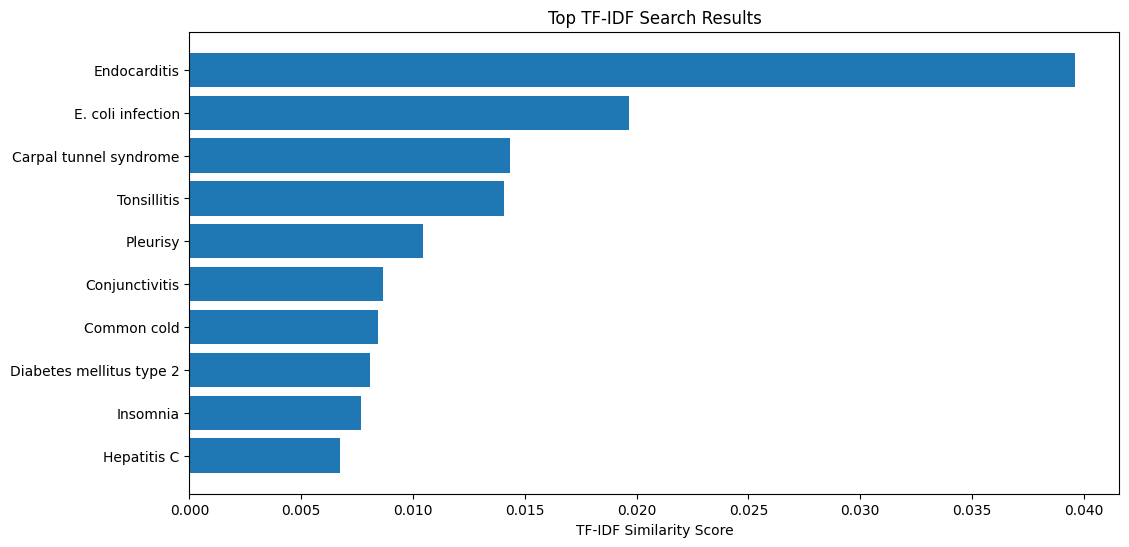

In [110]:
import matplotlib.pyplot as plt

# Plot top 10 TF-IDF scores
top_n = 10
top_idx = tfidf_scores.argsort()[::-1][:top_n]
titles = df.loc[top_idx, "title"].tolist()
scores = tfidf_scores[top_idx]

plt.figure(figsize=(12,6))
plt.barh(range(top_n), scores[::-1])
plt.yticks(range(top_n), titles[::-1])
plt.xlabel("TF-IDF Similarity Score")
plt.title("Top TF-IDF Search Results")
plt.show()


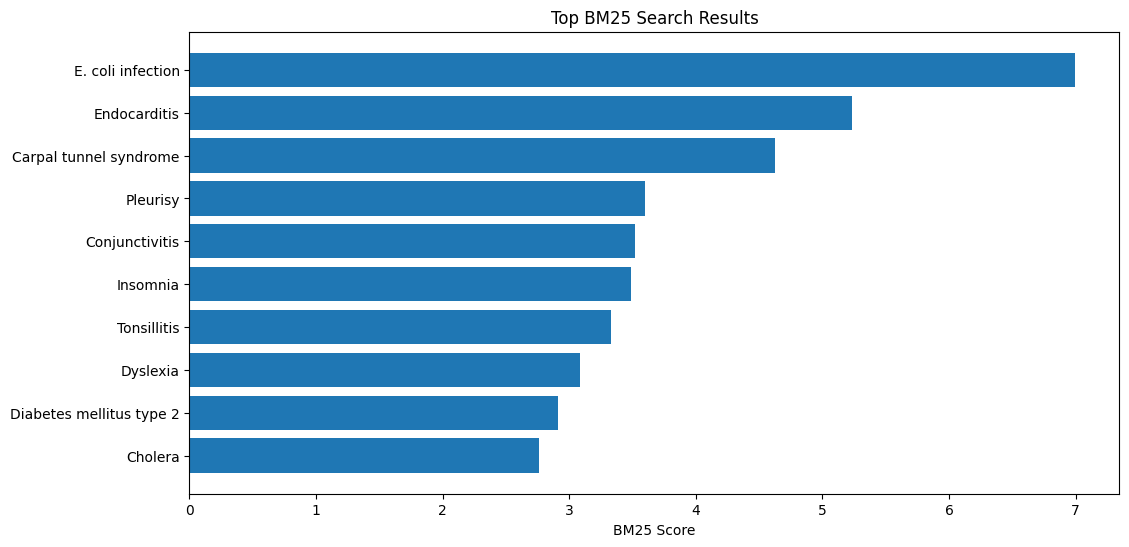

In [111]:
# Plot top 10 BM25 scores
top_n = 10
top_idx = np.argsort(bm25_scores)[::-1][:top_n]
titles = df.loc[top_idx, "title"].tolist()
scores = bm25_scores[top_idx]

plt.figure(figsize=(12,6))
plt.barh(range(top_n), scores[::-1])
plt.yticks(range(top_n), titles[::-1])
plt.xlabel("BM25 Score")
plt.title("Top BM25 Search Results")
plt.show()


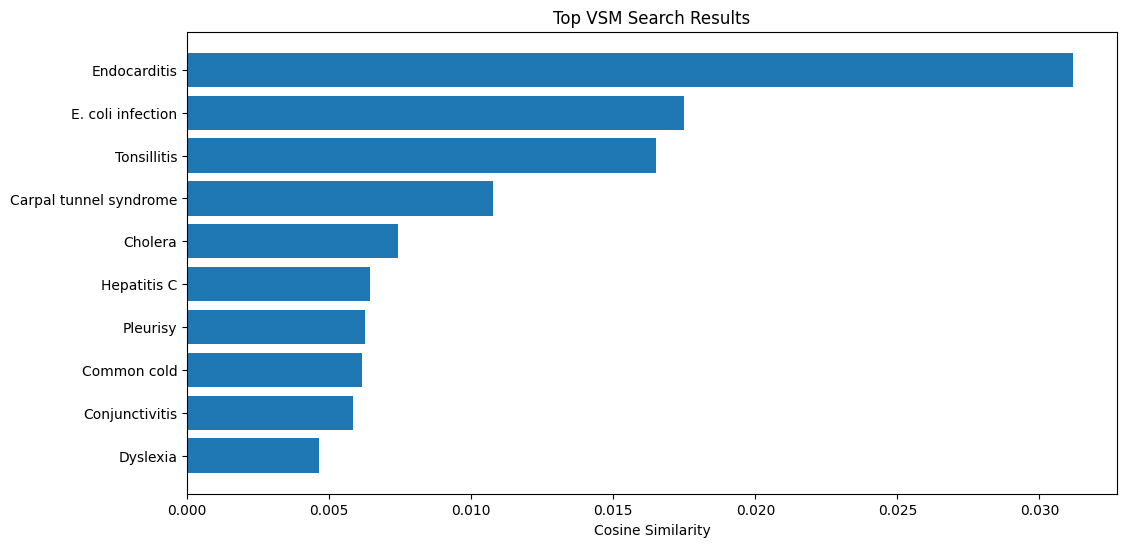

In [112]:
# Plot top 10 VSM cosine similarities
top_n = 10
top_idx = vsm_scores.argsort()[::-1][:top_n]
titles = df.loc[top_idx, "title"].tolist()
scores = vsm_scores[top_idx]

plt.figure(figsize=(12,6))
plt.barh(range(top_n), scores[::-1])
plt.yticks(range(top_n), titles[::-1])
plt.xlabel("Cosine Similarity")
plt.title("Top VSM Search Results")
plt.show()


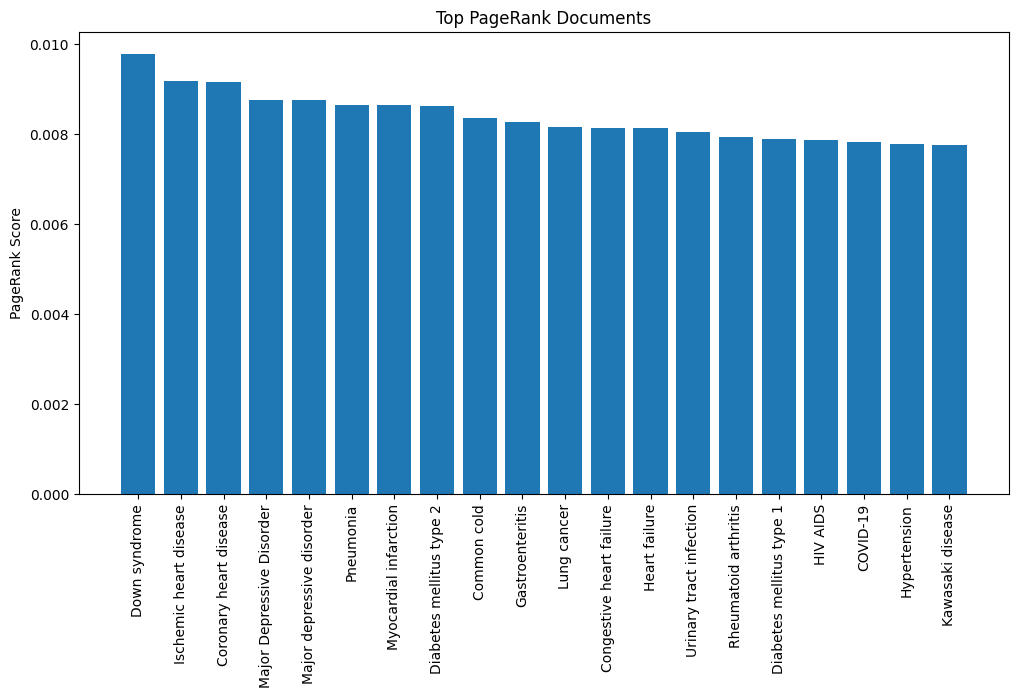

In [113]:
# Plot top 20 PageRank values
top_n = 20
pr_sorted = df.sort_values("pagerank", ascending=False).head(top_n)

plt.figure(figsize=(12,6))
plt.bar(pr_sorted["title"], pr_sorted["pagerank"])
plt.xticks(rotation=90)
plt.ylabel("PageRank Score")
plt.title("Top PageRank Documents")
plt.show()


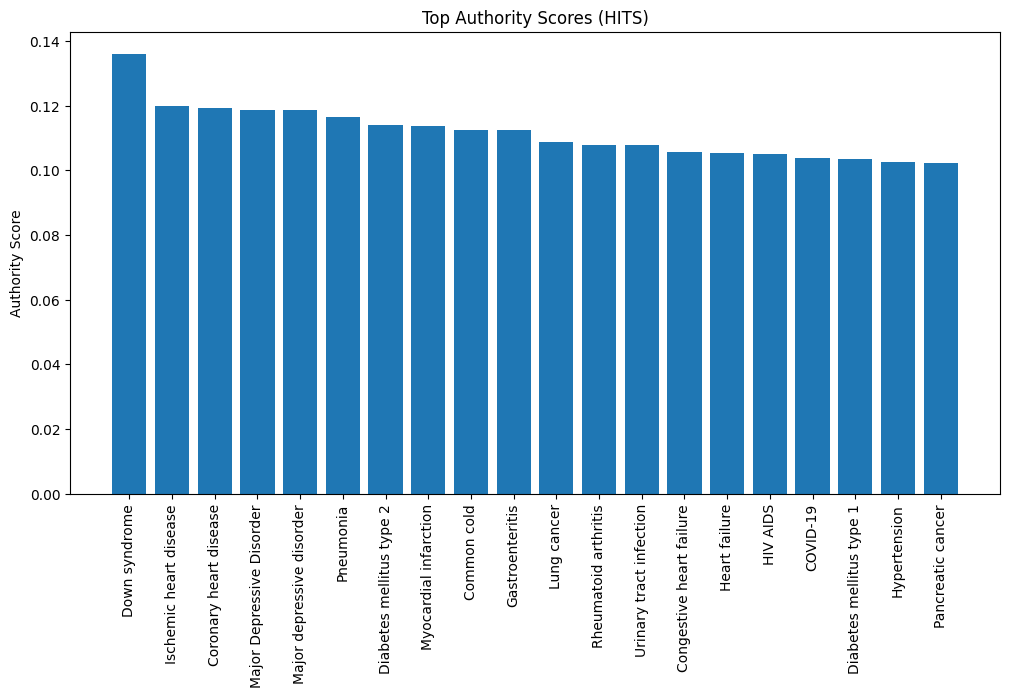

In [114]:
# Plot top 20 Authorities
top_n = 20
auth_sorted = df.sort_values("authority", ascending=False).head(top_n)

plt.figure(figsize=(12,6))
plt.bar(auth_sorted["title"], auth_sorted["authority"])
plt.xticks(rotation=90)
plt.ylabel("Authority Score")
plt.title("Top Authority Scores (HITS)")
plt.show()


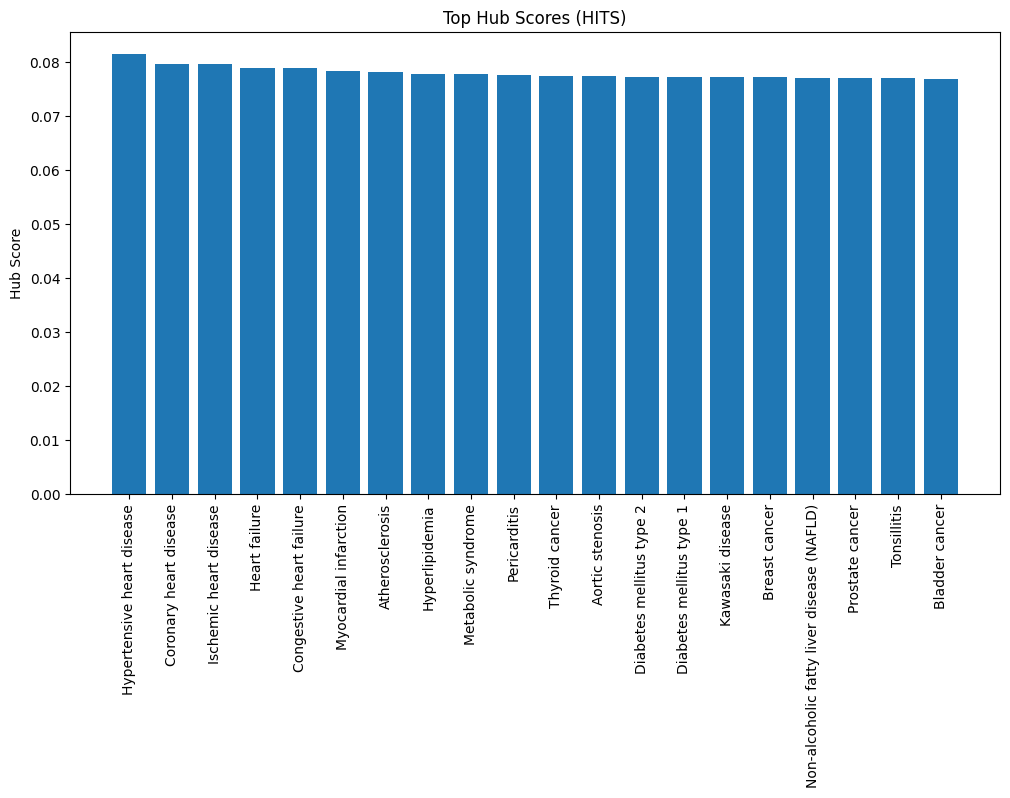

In [115]:
# Plot top 20 Hubs
top_n = 20
hub_sorted = df.sort_values("hub", ascending=False).head(top_n)

plt.figure(figsize=(12,6))
plt.bar(hub_sorted["title"], hub_sorted["hub"])
plt.xticks(rotation=90)
plt.ylabel("Hub Score")
plt.title("Top Hub Scores (HITS)")
plt.show()


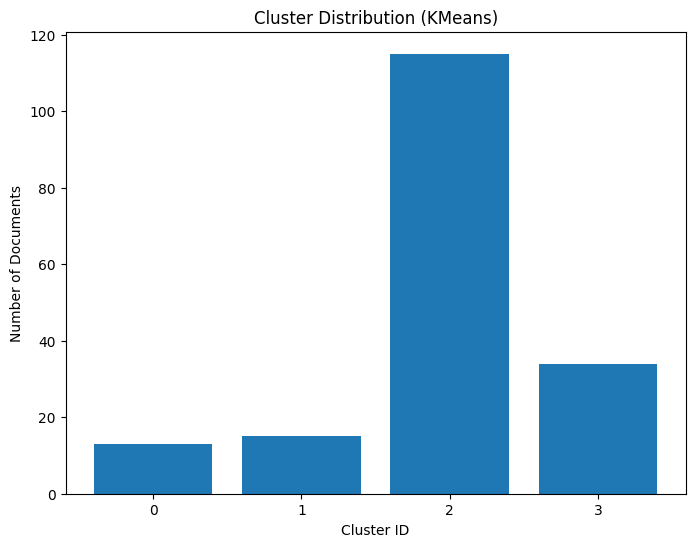

In [116]:
cluster_counts = df["cluster"].value_counts().sort_index()

plt.figure(figsize=(8,6))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Documents")
plt.title("Cluster Distribution (KMeans)")
plt.show()


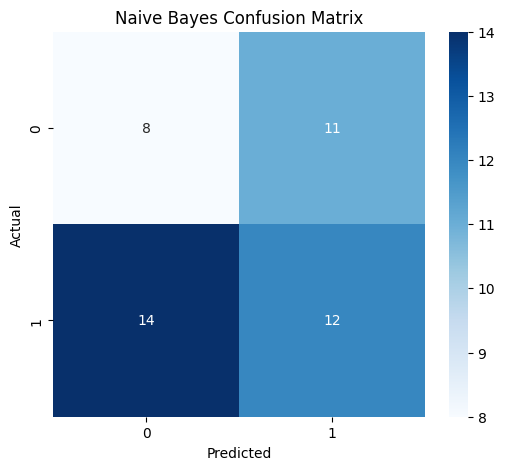

In [117]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds = nb.predict(X_test)
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes Confusion Matrix")
plt.show()


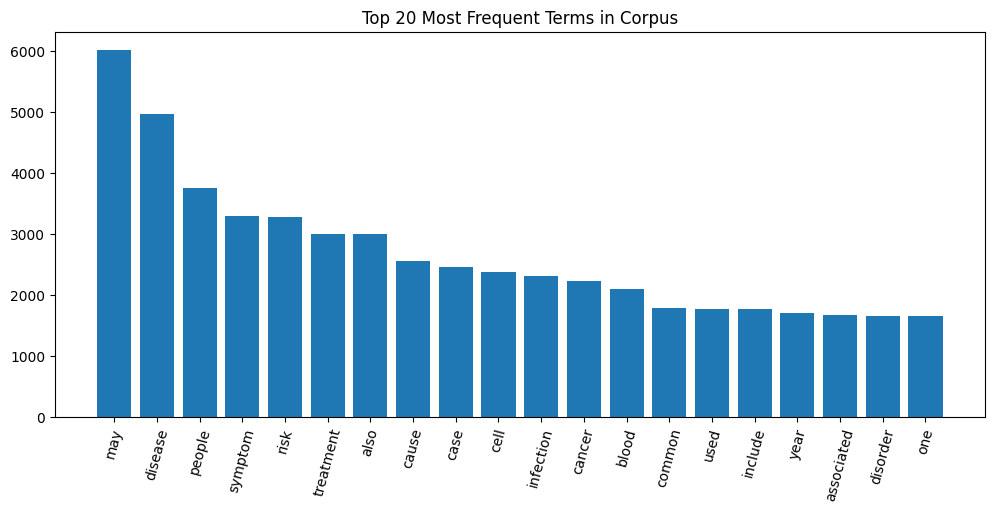

In [118]:
from collections import Counter

all_tokens = " ".join(df["clean"]).split()
freq = Counter(all_tokens).most_common(20)
words, counts = zip(*freq)

plt.figure(figsize=(12,5))
plt.bar(words, counts)
plt.xticks(rotation=75)
plt.title("Top 20 Most Frequent Terms in Corpus")
plt.show()


In [133]:
!pip install -q streamlit pyngrok rank_bm25 networkx seaborn

In [141]:
# ==========================================
# 1. INSTALL DEPENDENCIES
# ==========================================
!pip install -q streamlit rank_bm25 nltk scikit-learn pandas numpy

In [158]:
import os
import subprocess
import sys
import time

# ==========================================
# 1. INSTALL DEPENDENCIES
# ==========================================
print("📦 Installing dependencies (Streamlit, PyNgrok, etc.)...")
packages = ["streamlit", "rank_bm25", "nltk", "scikit-learn", "pandas", "numpy", "pyngrok", "networkx", "matplotlib", "seaborn"]
subprocess.check_call([sys.executable, "-m", "pip", "install"] + packages)

# ==========================================
# 2. DEFINE APP CODE
# ==========================================
# NOTE: We use r''' (raw string) to fix the SyntaxWarning about escape sequences like \s
app_source_code = r'''
import streamlit as st
import os
import re
import zipfile
import numpy as np
import pandas as pd
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
from rank_bm25 import BM25Okapi

# -----------------------------------------------------------------------------
# CONFIGURATION & NLTK SETUP
# -----------------------------------------------------------------------------
st.set_page_config(page_title="Medical Information Retrieval System", layout="wide", page_icon="🧬")

@st.cache_resource
def download_nltk_data():
    try:
        nltk.download("punkt", quiet=True)
        nltk.download("stopwords", quiet=True)
        nltk.download("wordnet", quiet=True)
        nltk.download("omw-1.4", quiet=True)
    except Exception as e:
        st.error(f"NLTK Download Error: {e}")

download_nltk_data()

# -----------------------------------------------------------------------------
# CORE FUNCTIONS (CLEANING & LOADING)
# -----------------------------------------------------------------------------
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    """Classic cleaning function: Lowercase, remove special chars, stopword removal, lemmatization."""
    text = (text or "").lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

def plot_kmeans_pca(df, tfidf_mat):
    # 1. Reduce dimensions to 2D
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(tfidf_mat.toarray())
    df["pca_x"] = reduced[:, 0]
    df["pca_y"] = reduced[:, 1]

    # 2. Generate Legend Labels (3 examples per cluster)
    cluster_labels = {}
    for cl in sorted(df["cluster"].unique()):
        names = df[df["cluster"] == cl]["title"].head(3).tolist()
        cluster_labels[cl] = ", ".join(names)

    # 3. Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    unique_clusters = sorted(df["cluster"].unique())
    colors = plt.cm.Set2(np.linspace(0, 1, len(unique_clusters)))

    for i, cl in enumerate(unique_clusters):
        points = df[df["cluster"] == cl]
        ax.scatter(
            points["pca_x"], points["pca_y"],
            color=colors[i], s=80, alpha=0.7,
            label=f"Cluster {cl}: {cluster_labels[cl]}"
        )

    ax.set_title("Disease Dataset - KMeans Clustering (2D PCA)", fontsize=14)
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    ax.grid(alpha=0.3)

    return fig

def plot_disease_graph(df, tfidf_mat, threshold=0.2):
    # 1. Build Similarity Matrix
    sim_matrix = cosine_similarity(tfidf_mat)

    # 2. Build Graph
    G = nx.Graph()
    for i, row in df.iterrows():
        G.add_node(i, label=row["title"])

    # Add edges based on threshold
    rows, cols = np.where(sim_matrix >= threshold)
    for r, c in zip(rows, cols):
        if r < c: # Avoid duplicates and self-loops
            G.add_edge(r, c, weight=sim_matrix[r, c])

    # 3. Calculate PageRank
    if len(G) > 0:
        pr = nx.pagerank(G, weight='weight')
        df["graph_pagerank"] = df.index.map(pr)

    # 4. Visualize
    fig, ax = plt.subplots(figsize=(20, 15))
    pos = nx.spring_layout(G, k=0.15, iterations=20)

    # Node sizes based on PageRank (or default if empty)
    if "graph_pagerank" in df.columns:
        sizes = [3000 * df.loc[n, "graph_pagerank"] for n in G.nodes()]
    else:
        sizes = 300

    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='#87CEFA', alpha=0.8, ax=ax)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3, edge_color='gray', ax=ax)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=8, font_color='black', ax=ax)

    ax.axis('off')
    return fig, df

@st.cache_data
def load_data(zip_path):
    """Extracts zip and creates a DataFrame."""
    if not os.path.exists(zip_path):
        return None

    docs = []
    try:
        with zipfile.ZipFile(zip_path, "r") as z:
            for name in z.namelist():
                if name.lower().endswith(".txt") and "__MACOSX" not in name:
                    raw = z.read(name).decode("utf-8", errors="ignore")
                    title = os.path.splitext(os.path.basename(name))[0]
                    docs.append((title, raw))
    except Exception as e:
        st.error(f"Error reading zip file: {e}")
        return None

    df = pd.DataFrame(docs, columns=["title", "text"])
    df["clean"] = df["text"].apply(clean_text)
    return df

# -----------------------------------------------------------------------------
# MODEL BUILDING (TF-IDF, BM25, VSM, INVERTED INDEX)
# -----------------------------------------------------------------------------
@st.cache_resource
def build_models(df):
    # 1. TF-IDF
    tfidf = TfidfVectorizer()
    tfidf_mat = tfidf.fit_transform(df["clean"])

    # 2. VSM (Count Vectorizer)
    vsm_vect = CountVectorizer()
    vsm_mat = vsm_vect.fit_transform(df["clean"])

    # 3. BM25
    tokenized_corpus = [doc.split() for doc in df["clean"]]
    bm25 = BM25Okapi(tokenized_corpus)

    # 4. Inverted Index
    inverted = defaultdict(set)
    for doc_id, text in enumerate(df["clean"]):
        for term in text.split():
            inverted[term].add(doc_id)

    return tfidf, tfidf_mat, vsm_vect, vsm_mat, bm25, inverted

# -----------------------------------------------------------------------------
# GRAPH ALGORITHMS (PAGERANK / HITS)
# -----------------------------------------------------------------------------
@st.cache_data
def run_graph_analysis(_tfidf_mat):
    # Create Similarity Matrix
    sim = (_tfidf_mat @ _tfidf_mat.T).toarray()
    np.fill_diagonal(sim, 0)
    row_sum = sim.sum(axis=1, keepdims=True)
    P = sim / (row_sum + 1e-12)

    # PageRank
    n = len(P)
    r = np.ones(n)/n
    d = 0.85
    for _ in range(100): # Max iter 100
        r_new = d*(P.T@r) + (1-d)/n
        if np.linalg.norm(r_new-r,1) < 1e-6: break
        r = r_new

    # HITS (Hubs & Authorities)
    h = np.ones(n)
    a = np.ones(n)
    for _ in range(100):
        a_new = P.T @ h
        h_new = P @ a_new
        a_new /= (np.linalg.norm(a_new) + 1e-12)
        h_new /= (np.linalg.norm(h_new) + 1e-12)
        a, h = a_new, h_new

    return r, h, a

# -----------------------------------------------------------------------------
# SEARCH LOGIC: EXPANSION & ROCCHIO
# -----------------------------------------------------------------------------
# ============================================================
#             SIMPLE EVALUATION FUNCTIONS
# ============================================================
def precision(relevant_set, retrieved_list):
    if len(retrieved_list) == 0:
        return 0.0
    # retrieved_list may be numpy array, ensure formatted correctly
    hits = sum(1 for d in retrieved_list if d in relevant_set)
    return hits / len(retrieved_list)

def recall(relevant_set, retrieved_list):
    if len(relevant_set) == 0:
        return 0.0
    hits = sum(1 for d in retrieved_list if d in relevant_set)
    return hits / len(relevant_set)

def f1(prec, rec):
    if prec + rec == 0:
        return 0.0
    return 2 * (prec * rec) / (prec + rec)

def expand_query_wordnet(query):
    q_clean = clean_text(query)
    tokens = q_clean.split()
    expanded = set(tokens)
    for word in tokens:
        for syn in wn.synsets(word):
            for lemma in syn.lemmas():
                name = lemma.name().replace("_", " ")
                if name.isalpha() and len(name) > 2:
                    expanded.add(name.lower())
    return " ".join(list(expanded))

def expand_query_corpus(query, df, tfidf, tfidf_mat):
    q_clean = clean_text(query)
    q_vec = tfidf.transform([q_clean])
    scores = cosine_similarity(q_vec, tfidf_mat).flatten()
    top_idx = scores.argsort()[::-1][:5] # Top 5 docs for expansion

    doc_text = " ".join(df.loc[i, "clean"] for i in top_idx)
    tokens = doc_text.split()
    freq = Counter(tokens)

    # Filter out rare words and query words
    filtered = [w for w in tokens if w.isalpha() and len(w)>2 and freq[w]>=2 and w not in q_clean.split()]

    if not filtered: return q_clean
    common_terms = [term for term, _ in Counter(filtered).most_common(5)]
    return q_clean + " " + " ".join(common_terms)

def rocchio_feedback(query_vec, relevant_docs, non_relevant_docs, tfidf_mat, alpha=1.0, beta=0.75, gamma=0.15):
    new_q = alpha * query_vec
    if len(relevant_docs) > 0:
        rel_vecs = tfidf_mat[relevant_docs].mean(axis=0)
        new_q = new_q + beta * rel_vecs
    if len(non_relevant_docs) > 0:
        nonrel_vecs = tfidf_mat[non_relevant_docs].mean(axis=0)
        new_q = new_q - gamma * nonrel_vecs
    return np.asarray(new_q)

# -----------------------------------------------------------------------------
# UI LAYOUT & MAIN APPLICATION
# -----------------------------------------------------------------------------
st.title("🧬 Medical Corpus Analytics & Search Engine")

# --- SIDEBAR: DATA LOADER ---
with st.sidebar:
    st.header("📂 Corpus Settings")
    zip_path = st.text_input("Path to Zip File", "/content/drive/MyDrive/wikipedia_corpus_clean.zip")

    if st.button("🚀 Load & Index Data"):
        st.session_state['load_trigger'] = True

if 'load_trigger' in st.session_state and st.session_state['load_trigger']:
    df = load_data(zip_path)
    if df is not None:
        st.success(f"Successfully loaded {len(df)} documents.")

        with st.spinner("Building Vector Space Models..."):
            tfidf, tfidf_mat, vsm_vect, vsm_mat, bm25, inverted = build_models(df)

        with st.spinner("Calculating PageRank & HITS..."):
            pr, hub, auth = run_graph_analysis(tfidf_mat)
            df["pagerank"] = pr
            df["hub"] = hub
            df["authority"] = auth

        st.session_state['data'] = (df, tfidf, tfidf_mat, vsm_vect, vsm_mat, bm25, inverted)
    else:
        st.error("Could not load file. Check path.")

# --- MAIN TABS ---
if 'data' in st.session_state:
    df, tfidf, tfidf_mat, vsm_vect, vsm_mat, bm25, inverted = st.session_state['data']

    tab_search, tab_cats, tab_stats, tab_network, tab_ml = st.tabs([
        "🔍 Search & Rocchio",
        "🗂️ Disease Groups",
        "📊 Dataset Stats",
        "🕸️ Network Analysis",
        "🤖 ML Models"
    ])

    # =========================================================
    # TAB 1: INTERACTIVE SEARCH WITH ROCCHIO
    # =========================================================
    with tab_search:
        st.subheader("Semantic Search Engine")

        c1, c2 = st.columns([3, 1])
        query_input = c1.text_input("Enter Query", "brain injury")
        method = c2.selectbox("Ranking Algorithm", ["TF-IDF", "BM25", "VSM"])

        exp_c1, exp_c2 = st.columns(2)
        use_wn = exp_c1.checkbox("Enable WordNet Expansion")
        use_corpus = exp_c2.checkbox("Enable Corpus-based Expansion")

        # Initialize session state for feedback loop
        if 'search_results' not in st.session_state: st.session_state['search_results'] = None
        if 'query_vec' not in st.session_state: st.session_state['query_vec'] = None

        if c1.button("Search"):
            final_q = query_input
            if use_wn: final_q = expand_query_wordnet(final_q)
            if use_corpus: final_q = expand_query_corpus(query_input, df, tfidf, tfidf_mat)

            st.info(f"**Processed Query:** {final_q}")
            q_clean = clean_text(final_q)

            if method == "TF-IDF":
                q_vec = tfidf.transform([q_clean])
                scores = cosine_similarity(q_vec, tfidf_mat).flatten()
            elif method == "VSM":
                q_vec = vsm_vect.transform([q_clean])
                scores = cosine_similarity(q_vec, vsm_mat).flatten()
            else: # BM25
                scores = np.array(bm25.get_scores(q_clean.split()))
                q_vec = tfidf.transform([q_clean]) # Fallback vector for Rocchio

            top_indices = scores.argsort()[::-1][:10]

            st.session_state['search_results'] = top_indices
            st.session_state['search_scores'] = scores
            st.session_state['query_vec'] = q_vec

        # Display Results & Feedback Controls
        if st.session_state['search_results'] is not None:
            top_idx = st.session_state['search_results']
            scores = st.session_state['search_scores']

            st.write("### 📄 Results")
            for i in top_idx:
                with st.expander(f"{i}: {df.loc[i, 'title']} (Score: {scores[i]:.4f})"):
                    st.write(df.loc[i, 'text'][:300] + "...")

            # --- START BAR CHART ADDITION ---
            st.markdown("---")
            st.subheader("📊 Top 10 Relevance Scores")

            # Prepare data
            top_scores = scores[top_idx]
            top_titles = df.loc[top_idx, "title"].tolist()

            # Plot
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.barh(range(len(top_scores)), top_scores[::-1], color="skyblue")
            ax.set_yticks(range(len(top_scores)))
            ax.set_yticklabels(top_titles[::-1])
            ax.set_xlabel("Similarity Score")
            ax.set_title("Top Search Results")
            st.pyplot(fig)

            # --- INSERT THIS NEW BLOCK ---
            st.markdown("---")
            st.subheader("📊 Top 10 BM25 Specific Scores")
            st.caption("Visualizing results specifically using the BM25 algorithm for comparison.")

            # 1. Recalculate BM25 scores for the current query text
            # (We do this on the fly so it works even if you searched with TF-IDF)
            q_bm25 = clean_text(query_input)
            bm25_scores_calc = np.array(bm25.get_scores(q_bm25.split()))

            # 2. Sort and get top N
            top_n = 10
            top_idx_bm25 = np.argsort(bm25_scores_calc)[::-1][:top_n]
            titles_bm25 = df.loc[top_idx_bm25, "title"].tolist()
            scores_bm25 = bm25_scores_calc[top_idx_bm25]

            # 3. Plot
            fig2, ax2 = plt.subplots(figsize=(12, 6))
            ax2.barh(range(top_n), scores_bm25[::-1], color="#90EE90") # Light green for distinction
            ax2.set_yticks(range(top_n))
            ax2.set_yticklabels(titles_bm25[::-1])
            ax2.set_xlabel("BM25 Score")
            ax2.set_title("Top BM25 Search Results")
            st.pyplot(fig2)
            # -----------------------------

            # --- INSERT THIS NEW BLOCK (VSM Chart) ---
            st.markdown("---")
            st.subheader("📊 Top 10 VSM Cosine Similarities")
            st.caption("Visualizing results specifically using Vector Space Model (Count Vectorizer) for comparison.")

            # 1. Calculate VSM scores on the fly for the current query
            # (Ensures this plot works even if you searched using TF-IDF or BM25)
            q_clean_vsm = clean_text(query_input)
            q_vec_vsm = vsm_vect.transform([q_clean_vsm])
            vsm_scores_calc = cosine_similarity(q_vec_vsm, vsm_mat).flatten()

            # 2. Sort and get top 10
            top_n = 10
            top_idx_vsm = vsm_scores_calc.argsort()[::-1][:top_n]
            titles_vsm = df.loc[top_idx_vsm, "title"].tolist()
            scores_vsm = vsm_scores_calc[top_idx_vsm]

            # 3. Plot
            fig3, ax3 = plt.subplots(figsize=(12, 6))
            # [::-1] reverses the list so the highest bar is at the top
            ax3.barh(range(top_n), scores_vsm[::-1], color="#FFB6C1") # Light pink color
            ax3.set_yticks(range(top_n))
            ax3.set_yticklabels(titles_vsm[::-1])
            ax3.set_xlabel("Cosine Similarity")
            ax3.set_title("Top VSM Search Results")
            st.pyplot(fig3)
            # -----------------------------------------



            # --- END BAR CHART ADDITION ---

            st.markdown("---")
            st.write("### 🧠 Relevance Feedback (Rocchio)")
            st.caption("Select documents to refine your search.")

            rc1, rc2 = st.columns(2)
            rel_docs = rc1.multiselect("✅ Relevant Documents", top_idx, format_func=lambda x: df.loc[x, 'title'])
            nonrel_docs = rc2.multiselect("❌ Non-Relevant Documents", top_idx, format_func=lambda x: df.loc[x, 'title'])

            if st.button("Apply Rocchio & Rerank"):
                if not rel_docs and not nonrel_docs:
                    st.warning("Please select at least one document for feedback.")
                else:
                    # 1. Apply Rocchio (Existing Code)
                    old_vec = st.session_state['query_vec']
                    new_vec = rocchio_feedback(old_vec, rel_docs, nonrel_docs, tfidf_mat)

                    new_scores = cosine_similarity(new_vec, tfidf_mat).flatten()
                    new_top = new_scores.argsort()[::-1][:10]

                    st.success("Reranking Complete!")

                    # --- ADD THIS EVALUATION SECTION HERE ---
                    st.subheader("📉 Evaluation Metrics (New Ranking vs. Your Feedback)")

                    # Ground Truth = The docs you explicitly marked as Relevant
                    relevant_set = set(rel_docs)

                    # Retrieved = The new Top 10 list produced by Rocchio
                    retrieved_list = new_top

                    # Calculate Stats
                    prec = precision(relevant_set, retrieved_list)
                    rec = recall(relevant_set, retrieved_list)
                    f1_score = f1(prec, rec)

                    # Display Metrics
                    em1, em2, em3 = st.columns(3)
                    em1.metric("Precision", f"{prec:.2f}")
                    em2.metric("Recall", f"{rec:.2f}")
                    em3.metric("F1 Score", f"{f1_score:.2f}")
                    # ----------------------------------------

                    # 2. Show New Results Table (Existing Code)
                    results_data = [{"Doc ID": i, "Title": df.loc[i, "title"], "New Score": new_scores[i]} for i in new_top]
                    st.table(pd.DataFrame(results_data))

    # =========================================================
    # TAB 2: DISEASE CATEGORIES
    # =========================================================
    with tab_cats:
        st.header("🗂️ Disease Classifications")

        groups = {
            ("🦠 Infectious Diseases", "#d9534f"): ["Syphilis", "Herpes simplex", "Toxoplasmosis", "Ebola virus disease", "Hepatitis C", "Rubella", "Warts", "Otitis media"],
            ("🫁 Respiratory Diseases", "#5bc0de"): ["Asthma", "Lung cancer", "Pneumoconiosis", "Vertigo"],
            ("🍔 Metabolic Disorders", "#f0ad4e"): ["Metabolic syndrome", "Hyperlipidemia", "Hypertension", "Non-alcoholic fatty liver disease (NAFLD)", "Gout"],
            ("🧠 Neurological Disorders", "#428bca"): ["Concussion", "Huntington's disease", "Cerebral palsy", "Vertigo"],
            ("😔 Mental Health", "#6f42c1"): ["Major depressive disorder", "Anxiety disorder", "Generalized Anxiety Disorder", "Attention-Deficit Hyperactivity Disorder"],
            ("🧬 Genetic Disorders", "#5cb85c"): ["Cystic fibrosis", "Ehlers-Danlos syndrome", "Hemochromatosis", "Celiac disease"],
            ("🧪 Immune Disorders", "#0275d8"): ["Celiac disease", "Allergies", "Asthma"],
            ("🩺 Gastrointestinal", "#d58512"): ["Gastroesophageal Reflux Disease", "Non-alcoholic fatty liver disease (NAFLD)", "Celiac disease"],
            ("🦴 Musculoskeletal", "#8a6d3b"): ["Gout", "Ehlers-Danlos syndrome"]
        }

        cols = st.columns(3)
        idx = 0
        for (name, color), diseases in groups.items():
            with cols[idx % 3]:
                st.markdown(f"""
                    <div style="background-color: {color}; padding: 10px; border-radius: 5px 5px 0 0; color: white; font-weight: bold;">
                        {name}
                    </div>
                """, unsafe_allow_html=True)

                # Create a clean list display
                for d in diseases:
                    st.markdown(f"<div style='border-bottom: 1px solid #eee; padding: 5px;'>• {d}</div>", unsafe_allow_html=True)
                st.markdown("<br>", unsafe_allow_html=True)
            idx += 1

    # =========================================================
    # TAB 3: DATASET STATS (INVERTED INDEX)
    # =========================================================
    with tab_stats:
        st.header("Corpus Statistics")
        m1, m2, m3 = st.columns(3)
        m1.metric("Total Documents", len(df))
        m2.metric("Vocabulary Size", len(tfidf.vocabulary_))
        m3.metric("Matrix Shape", str(tfidf_mat.shape))

        st.subheader("📖 Inverted Index Inspector")
        term = st.text_input("Look up term in index:", "concussion")
        if term:
            term_clean = lemmatizer.lemmatize(term.lower())
            if term_clean in inverted:
                doc_ids = sorted(list(inverted[term_clean]))
                st.write(f"Term **'{term_clean}'** appears in {len(doc_ids)} documents:")
                st.write(doc_ids)
            else:
                st.warning(f"Term '{term}' not found in vocabulary.")

        with st.expander("View Full Document List"):
            st.dataframe(df[["title"]])

        # --- ADD THIS HERE ---
        st.markdown("---")
        st.subheader("🔤 Top 20 Most Frequent Words")

        all_tokens = " ".join(df["clean"]).split()
        freq = Counter(all_tokens).most_common(20)
        words, counts = zip(*freq)

        fig_freq, ax_freq = plt.subplots(figsize=(12, 5))
        ax_freq.bar(words, counts, color="#66c2a5")
        ax_freq.set_xticklabels(words, rotation=45, ha="right")
        ax_freq.set_title("Top 20 Most Frequent Terms in Corpus")
        st.pyplot(fig_freq)



    # =========================================================
    # TAB 4: NETWORK ANALYSIS
    # =========================================================
    with tab_network:
        st.header("🕸️ Disease Similarity Graph")

        # Slider to control graph density
        threshold = st.slider("Similarity Threshold (Lower = More Edges)", 0.1, 0.5, 0.2, 0.05)

        if st.button("Generate Graph"):
            with st.spinner("Building Graph & Calculating PageRank..."):
                fig, updated_df = plot_disease_graph(df, tfidf_mat, threshold)

                # Show the Plot
                st.pyplot(fig)

                # Show the new PageRank stats
                st.subheader("Graph-Based PageRank Scores")
                if "graph_pagerank" in updated_df.columns:
                    st.dataframe(updated_df.sort_values("graph_pagerank", ascending=False)[["title", "graph_pagerank"]].head(15))

         # --- ADD THE NEW CODE BELOW HERE ---
        st.markdown("---")
        st.subheader("📊 Global Network Metrics (PageRank & HITS)")

        nc1, nc2, nc3 = st.tabs(["PageRank Plot", "Authority Plot", "Hub Plot"])

        with nc1:
            top_n = 20
            pr_sorted = df.sort_values("pagerank", ascending=False).head(top_n)
            fig_pr, ax_pr = plt.subplots(figsize=(10, 5))
            ax_pr.bar(pr_sorted["title"], pr_sorted["pagerank"], color="#ffd92f")
            ax_pr.set_xticklabels(pr_sorted["title"], rotation=90)
            ax_pr.set_ylabel("PageRank Score")
            ax_pr.set_title("Top 20 PageRank Documents")
            st.pyplot(fig_pr)

        with nc2:
            top_n = 20
            auth_sorted = df.sort_values("authority", ascending=False).head(top_n)
            fig_au, ax_au = plt.subplots(figsize=(10, 5))
            ax_au.bar(auth_sorted["title"], auth_sorted["authority"], color="#fc8d62")
            ax_au.set_xticklabels(auth_sorted["title"], rotation=90)
            ax_au.set_ylabel("Authority Score")
            ax_au.set_title("Top 20 Authority Scores (HITS)")
            st.pyplot(fig_au)

        with nc3:
            top_n = 20
            hub_sorted = df.sort_values("hub", ascending=False).head(top_n)
            fig_hub, ax_hub = plt.subplots(figsize=(10, 5))
            ax_hub.bar(hub_sorted["title"], hub_sorted["hub"], color="#8da0cb")
            ax_hub.set_xticklabels(hub_sorted["title"], rotation=90)
            ax_hub.set_ylabel("Hub Score")
            ax_hub.set_title("Top 20 Hub Scores (HITS)")
            st.pyplot(fig_hub)


    # =========================================================
    # TAB 5: ML MODELS
    # =========================================================
    with tab_ml:
        st.header("Machine Learning Models")

        col1, col2 = st.columns(2)

        with col1:
            st.subheader("🧩 K-Means Clustering")
            k_val = st.slider("Number of Clusters", 2, 10, 4)
            if st.button("Train K-Means"):
                # 1. Run K-Means
                kmeans = KMeans(n_clusters=k_val, n_init=10).fit(tfidf_mat)
                df["cluster"] = kmeans.labels_
                st.success(f"Clustered into {k_val} groups.")

                # 2. Show PCA Visualization (NEW)
                st.markdown("### 2D PCA Projection")
                fig_pca = plot_kmeans_pca(df, tfidf_mat)
                st.pyplot(fig_pca)

                # 3. Show Stats
                st.bar_chart(df["cluster"].value_counts())

                for i in range(k_val):
                    with st.expander(f"View Cluster {i}"):
                        st.write(df[df["cluster"] == i]["title"].tolist())

        with col2:
            st.subheader("🤖 Naive Bayes Classification")
            st.markdown("*Toy example: Classifying even vs odd index docs*")
            if st.button("Train Naive Bayes"):
                X = vsm_mat
                y = df.index % 2
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                nb = MultinomialNB().fit(X_train, y_train)
                acc = nb.score(X_test, y_test)
                st.metric("Model Accuracy", f"{acc:.2%}")

                # Sample predictions
                sample_preds = nb.predict(X_test[:5])
                st.write("Sample Predictions:", pd.DataFrame({"True": y_test[:5], "Pred": sample_preds}))

                # Confusion Matrix
                st.markdown("#### Confusion Matrix")
                preds = nb.predict(X_test) # Predict on ALL test data
                cm = confusion_matrix(y_test, preds)

                fig_cm, ax_cm = plt.subplots(figsize=(6, 4))
                sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", ax=ax_cm)
                ax_cm.set_xlabel("Predicted")
                ax_cm.set_ylabel("Actual")
                ax_cm.set_title("Naive Bayes Confusion Matrix")
                st.pyplot(fig_cm)

else:
    st.info("👈 Waiting for data load...")
'''

# ==========================================
# 3. WRITE THE APP FILE
# ==========================================
with open("app.py", "w", encoding='utf-8') as f:
    f.write(app_source_code)

print("✅ app.py created successfully!")

# ==========================================
# 4. RUN STREAMLIT & NGROK
# ==========================================
from pyngrok import ngrok

# --- ADD THIS LINE HERE ---
print("0. Killing previous ngrok sessions...")
ngrok.kill()

print("----------------------------------------------------")
print("1. Starting Streamlit in Background...")
# Run Streamlit in the background
streamlit_process = subprocess.Popen(["streamlit", "run", "app.py"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
time.sleep(5) # Give it a moment to start

print("2. Authenticating Ngrok...")
# ----------------------------------------------------------------
# ⚠️ IMPORTANT: YOU MUST PASTE YOUR NGROK TOKEN BELOW WHEN PROMPTED
# Get it from: https://dashboard.ngrok.com/get-started/your-authtoken
# ----------------------------------------------------------------
ngrok_auth_token = input("📋 Enter your Ngrok Authtoken here: ").strip()

if ngrok_auth_token:
    try:
        ngrok.set_auth_token(ngrok_auth_token)
        print("✅ Ngrok Authenticated!")

        print("3. Creating Tunnel...")
        public_url = ngrok.connect(8501).public_url
        print(f"\n🚀 YOUR APP IS LIVE AT: {public_url}")
        print("(Click the link above to open the app)")

        # Keep the cell running
        print("\nPress Ctrl+C to stop the server.")
        try:
            while True:
                time.sleep(1)
        except KeyboardInterrupt:
            print("\nStopping...")
            ngrok.kill()
            streamlit_process.kill()

    except Exception as e:
        print(f"❌ Error connecting Ngrok: {e}")
else:
    print("❌ No token provided. Please re-run and paste the token.")

📦 Installing dependencies (Streamlit, PyNgrok, etc.)...
✅ app.py created successfully!
0. Killing previous ngrok sessions...
----------------------------------------------------
1. Starting Streamlit in Background...
2. Authenticating Ngrok...
📋 Enter your Ngrok Authtoken here: 35m9eJCZMShYBqq1EI5P7p0DVQ4_6y2RQrPkN4RdxQxbqr2EW
✅ Ngrok Authenticated!
3. Creating Tunnel...


❌ Error connecting Ngrok: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: The endpoint 'https://hydrocarbonaceous-caitlyn-dressiest.ngrok-free.dev' is already online. Either\n1. stop your existing endpoint first, or\n2. start both endpoints with `--pooling-enabled` to load balance between them.\r\n\r\nERR_NGROK_334\r\n"}}

